In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score

snr_list = ['6_dB', '-6_dB', '0_dB']

def read_csv_files(target, pattern='anomaly_score_*.csv'):
    return glob.glob(os.path.join(target, pattern))

    
# 파일 이름에서 레이블을 결정하는 함수
def get_label(filename):
    if 'abnormal' in filename:
        return 1
    else:
        return 0

def get_labels_and_scores(csv_files):
    actual_labels = []
    anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores)



In [5]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    abnormal_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        abnormal_score = df[df['label']==1]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
        abnormal_scores.extend(abnormal_score)
    return actual_labels, anomaly_scores, normal_anomaly_scores, abnormal_scores

1529
1529
              pred   gt
1536  7.152555e-07  1.0
1631  7.152555e-07  1.0
1632  1.370898e-05  1.0
1633 -0.000000e+00  1.0
1635  2.980228e-06  1.0
...            ...  ...
2810  2.384185e-07  1.0
2811  1.192093e-07  1.0
2812 -0.000000e+00  1.0
2813 -0.000000e+00  1.0
2962  3.457064e-06  1.0

[220 rows x 2 columns]


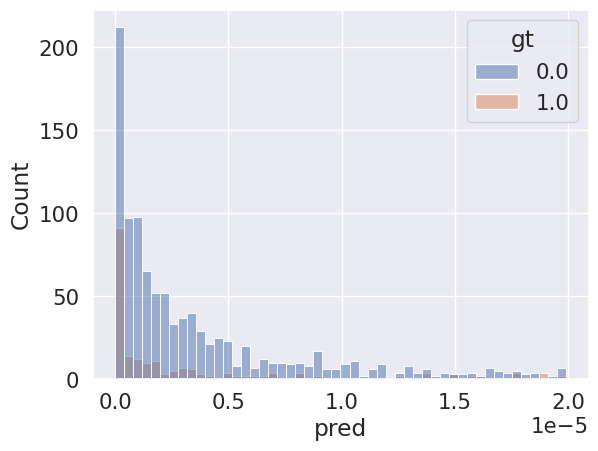

In [13]:
def draw_anomaly_score(anomaly_scores, abnormal_scores):
    anomaly_scores = np.array(anomaly_scores)
    abnormal_scores = np.array(abnormal_scores)

    # print(anomaly_scores.shape)
    # print(abnormal_scores.shape)

    normal_labels = np.zeros_like(anomaly_scores)
    abnormal_labels = np.zeros_like(abnormal_scores) + 1

    scores = np.hstack((anomaly_scores, abnormal_scores)).tolist()
    labels = np.hstack((normal_labels, abnormal_labels)).tolist()

    target_df = pd.DataFrame({"pred": scores, "gt": labels})
    target_df = target_df[target_df["pred"] < 0.00002]
    print(target_df[(target_df["pred"] < 0.00002) & (target_df["gt"] == 1.0)])

    sns.histplot(data=target_df, hue="gt", x="pred", bins=50)

def process_anomaly_score(test=False):
    csv_files = read_csv_files('./test')
    # print(sorted(csv_files))
    actual_labels, tot, normal_anomaly_scores, abnormal_scores = get_labels_and_scores_n(csv_files)
    # print(len(tot))
    print(len(normal_anomaly_scores))
    print(len(abnormal_scores))
    auc = roc_auc_score(actual_labels, tot)
    # print(auc)
    draw_anomaly_score(normal_anomaly_scores, abnormal_scores)
    

process_anomaly_score(test=True)

Optimal threshold: 0.0001811817
F1 Score: 0.7981220657276994


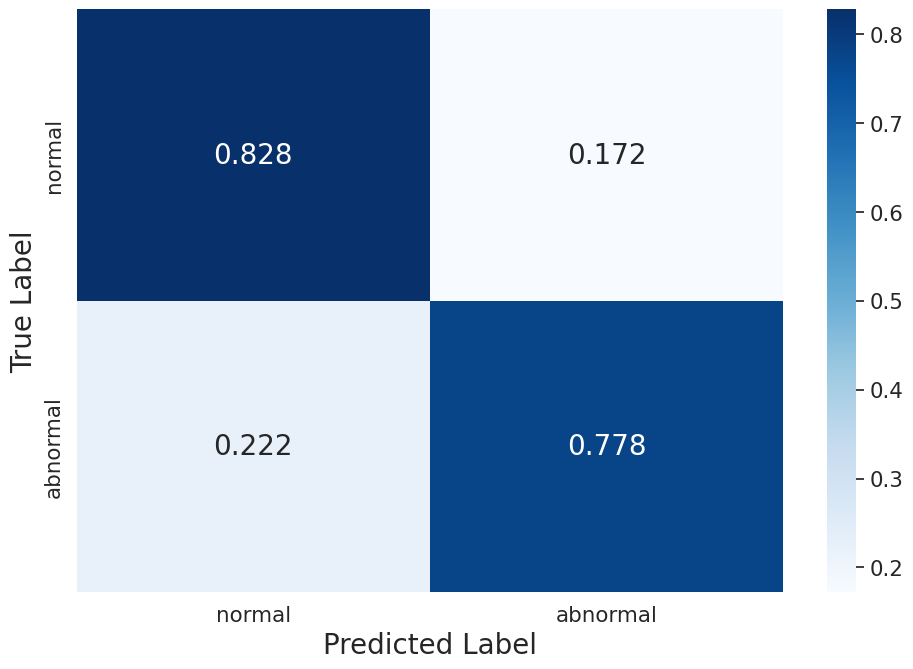

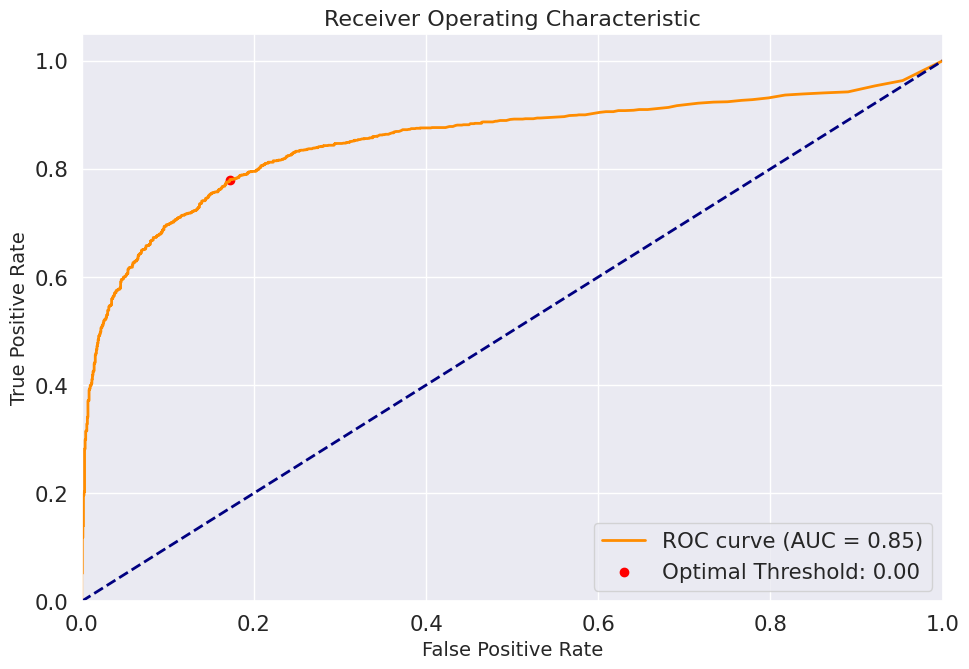

In [7]:
def calculate_metrics(actual_labels, anomaly_scores):
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    # print(thresholds)
    roc_auc = auc(fpr, tpr)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    f1 = f1_score(actual_labels, predicted_labels)
    return predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    plt.close() 

def draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, test=False):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_Youden_inede(test=False):
    csv_files = read_csv_files('./test')
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics(actual_labels, anomaly_scores)
    predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1 = results
    
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, test)
    
    # return results

use_Youden_inede(test=True)

Z-Score Threshold: 1.5
F1 Score: 0.6290748898678414


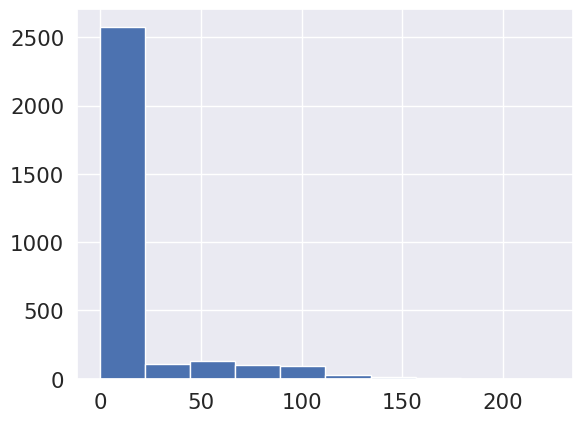

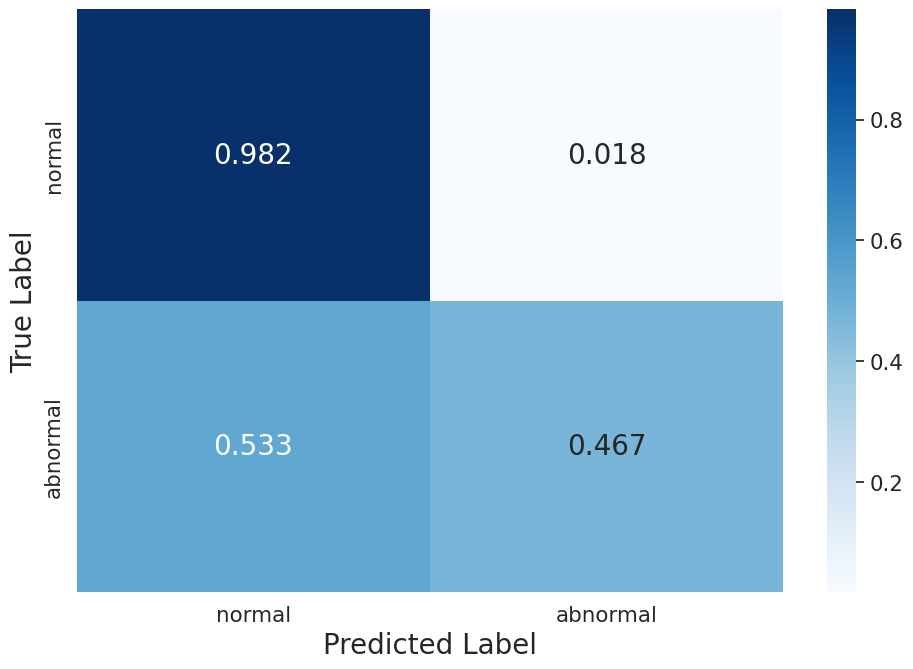

In [8]:
def read_csv_files(target, pattern='anomaly_score_*.csv'):
    return glob.glob(os.path.join(target, pattern))
    

def calculate_metrics_zscore(actual_labels, normal_anomaly_scores, anomaly_scores, z_threshold=1.5):
    normal_mean = np.mean(normal_anomaly_scores)
    # print(normal_mean)
    normal_std = np.std(normal_anomaly_scores)

    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    plt.hist(z_scores)
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)
    # print(predicted_labels)
    # print(actual_labels)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)


    plt.tight_layout()
    plt.show()
    plt.close() 

def use_zscore():
    train_csv_files = read_csv_files('./train')
    # print(train_csv_files)
    train_actual_labels, train_tot, train_normal_anomaly_scores, train_abnormal_scores = get_labels_and_scores_n(train_csv_files)

    test_csv_files = read_csv_files('./test')
    # print(sorted(train_csv_files))
    test_actual_labels, test_tot, test_normal_anomaly_scores, test_abnormal_scores = get_labels_and_scores_n(test_csv_files)
    # print(test_actual_labels)

    results = calculate_metrics_zscore(test_actual_labels, train_normal_anomaly_scores, test_tot)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(test_actual_labels, predicted_labels)
    
    # return results


use_zscore()


Z-Score Threshold: 3.5
F1 Score: 0.7929155313351498


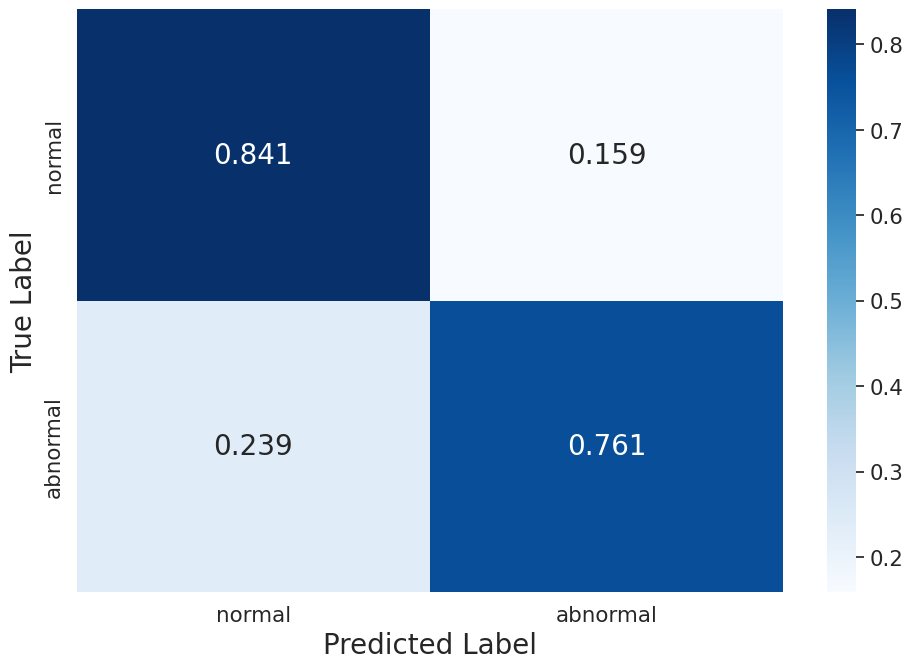

In [9]:
def calculate_metrics_modified_zscore(actual_labels, anomaly_scores, normal_anomaly_scoresm, z_threshold=3.5):
    median = np.median(normal_anomaly_scoresm)
    median_absolute_deviation = np.median(np.abs(normal_anomaly_scoresm-median))

    # Z-Score 계산
    modified_z_scores = 0.6745*(anomaly_scores - median) / median_absolute_deviation
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (np.abs(modified_z_scores) > z_threshold).astype('int')

    # print(len(actual_labels))
    # print(len(predicted_labels))
    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)


    return predicted_labels, z_threshold, f1
    

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)


    # plt.title(f'{sn, pad=20, fontsize=20)
    plt.tight_layout()
    plt.show()
    plt.close() 

def use_modified_zscore(test=False):

    train_csv_files = read_csv_files('./train')
    # print(train_csv_files)
    train_actual_labels, train_tot, train_normal_anomaly_scores, train_abnormal_scores = get_labels_and_scores_n(train_csv_files)

    test_csv_files = read_csv_files('./test')
    # print(sorted(train_csv_files))
    test_actual_labels, test_tot, test_normal_anomaly_scores, test_abnormal_scores = get_labels_and_scores_n(test_csv_files)
    # print(test_actual_labels)

    results = calculate_metrics_modified_zscore(test_actual_labels, test_tot, train_normal_anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(test_actual_labels, predicted_labels)
    
    # return results


use_modified_zscore(test=True)


In [10]:
def max_f1score(actual_labels, anomaly_scores):
    precision, recall, thresholds = precision_recall_curve(actual_labels, anomaly_scores)
    f1_score =  2 * (precision * recall) / (precision + recall)

    optimal_idx = np.argmax(f1_score)
    optimal_threshold = thresholds[optimal_idx]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)

    # Precision-Recall Curve 시각화
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold}')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(f'Precision-Recall Curve', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold, predicted_labels, f1_score[optimal_idx]

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        # plt.title(f'{/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        # plt.title(f'{', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.show() 

def use_max_f1(test=False):
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    optimal_threshold, predicted_labels, f1 = max_f1score(actual_labels, anomaly_scores) 
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    AUPRC = average_precision_score(actual_labels, anomaly_scores)

    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    print(f'Average Precision Score: {AUPRC}')

use_max_f1(test=False)


TypeError: read_csv_files() got an unexpected keyword argument 'test'